In [1]:
import os
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
# run this if using kaggle notebooks
!cp -r ../input/lux-ai-2021/* .
# if working locally, download the `simple/lux` folder from here https://github.com/Lux-AI-Challenge/Lux-Design-2021/tree/master/kits/python
# and we recommend following instructions in there for local development with python bots

# for kaggle-environments
from lux.game import Game
from lux.game_map import Cell, RESOURCE_TYPES, Position
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS
from lux import annotate
import math
import sys
from kaggle_environments import make

Loading environment football failed: No module named 'gfootball'


# Feature extraction

In [3]:
class ResourceFeatures:
    def __init__(self, game_state):
        self.game_state=game_state
        
    def get_resource_features(self, cell):
        resource_feats=np.zeros(3)
        
        resource=cell.resource
        resource_amount=0
        resource_type=0
        if cell.has_resource():
            resource_amount=resource.amount

        #0-no resource, 1-wood, 2-coal, 3-uranium
        if cell.has_resource() and RESOURCE_TYPES.WOOD == resource.type:
            resource_feats[0]=(resource_amount - 521.49)/219.398
        elif cell.has_resource() and RESOURCE_TYPES.COAL == resource.type:
            resource_feats[1]=( resource_amount  - 388.595)/21.614
        elif cell.has_resource() and RESOURCE_TYPES.URANIUM == resource.type:
            resource_feats[2]=(resource_amount-324.63)/14.55
        return resource_feats
    
    def get_grid_resources(self, game_state):
        cell_feats=[]
        self.game_state=game_state
        game_map = self.game_state.map
        (width, height) = (game_map.width, game_map.height)
        resource_feats=np.zeros( (width, height, 3) )
        for i in range(width):
            for j in range(height):
                cell = game_map.get_cell(i, j)    
                r_feats=self.get_resource_features(cell)
                resource_feats[i][j]=r_feats
        return resource_feats
    
class CityFeatures:
    def __init__(self, game_state):
        self.game_state=game_state
    def get_adjacent_friendly_tile_counts(self, x, y, fuel, citytiles):
        num_tiles=0
        for citytile in citytiles:
            (adjx, adjy) = (citytile.pos.x, citytile.pos.y)
            if x==adjx and y==adjy:
                continue
            if num_tiles==4:
                break
            if x==1+adjx and y==adjy:
                num_tiles+=1
            elif x==adjx and y==1+adjy:
                num_tiles+=1
            elif x == adjx-1 and y==adjy:
                num_tiles+=1
            elif x==adjx and y==adjy-1:
                num_tiles+=1
        return num_tiles
        
    def get_city_features(self, game_state):
        self.game_state=game_state
        
        turn=self.game_state.turn
        team=self.game_state.id
        players=self.game_state.players
        game_map = self.game_state.map
        (width, height) = (game_map.width, game_map.height)
        
        city_feats=np.zeros((width, height, 6))
        for player in players:
            cities=player.cities
            for city_id, city in cities.items():
                fuel=city.fuel
                fuel_per_citytile=fuel/len(city.citytiles)
                city_team=city.team
                
                opp_team=1
                if city_team==team:
                    opp_team=0
                    
                for city_tile in city.citytiles:
                    cooldown=city_tile.cooldown
                    (x, y) = (city_tile.pos.x, city_tile.pos.y)
                    num_tiles=self.get_adjacent_friendly_tile_counts(x, y, fuel, city.citytiles)
                    fuel_required_to_survive = (23 - 5*num_tiles) * 10

                    city_feats[x][y][0] = opp_team
                    city_feats[x][y][1] = 1-opp_team
                    city_feats[x][y][2] = cooldown
                    city_feats[x][y][3] = min(1, fuel_per_citytile/230) #clipping range [0, 1]
                    city_feats[x][y][4] = fuel_required_to_survive/230 #always be [0, 1]
                    city_feats[x][y][5] = min(0, (fuel_per_citytile - fuel_required_to_survive)/230)#Clips [-1, 0]
        return city_feats

class UnitFeatures:
    def __init__(self, game_state):
        self.game_state=game_state
    def get_unit_feats(self, game_state):
        self.game_state=game_state
        turn=self.game_state.turn
        team=self.game_state.id
        players=self.game_state.players
        game_map = self.game_state.map
        (width, height) = (game_map.width, game_map.height)
        
        unit_feats=np.zeros((width, height, 9))
        for player in players:
            units=player.units
            for unit in units:
                (x, y) = (unit.pos.x, unit.pos.y)
                opp_team = 0 if (unit.team==team) else 1
                cooldown=unit.cooldown
                unit_type=unit.type
                max_cargo=100
                if unit_type == 1:
                    max_cargo=2000
                cargo_wood=unit.cargo.wood/max_cargo
                cargo_coal=unit.cargo.coal/max_cargo
                cargo_uranium=unit.cargo.uranium/max_cargo
                cargo_space_left=unit.get_cargo_space_left()/max_cargo

                unit_feats[x][y][0]=opp_team
                unit_feats[x][y][1]=1-opp_team
                unit_feats[x][y][2]=cooldown

                unit_feats[x][y][3]=cargo_wood
                unit_feats[x][y][4]=cargo_coal
                unit_feats[x][y][5]=cargo_uranium
                unit_feats[x][y][6]=cargo_space_left

                #unit_type = 0 if cart
                #unit type=1 if worker
                
                unit_feats[x][y][7]=1-unit_type #1 if worker
                unit_feats[x][y][8]=unit_type
                
        return unit_feats

In [4]:
class GameFeatures:
    def __init__(self, game_state):
        self.game_state=game_state
        self.resource_features=ResourceFeatures(game_state)
        self.unit_features=UnitFeatures(game_state)
        self.city_features=CityFeatures(game_state)
        
    def get_map_features(self, game_state):
        resource_feats=self.resource_features.get_grid_resources(game_state)
        city_feats=self.city_features.get_city_features(game_state)
        unit_feats=self.unit_features.get_unit_feats(game_state)
        feats=np.concatenate([resource_feats, city_feats, unit_feats ], axis=2)
        return feats
    
    def get_private_features(self, feats, x, y):
        (W, H) = (feats.shape[0], feats.shape[1])
        w=4; h=4
        
        (x1, x2) = (x-w, x+w)
        (y1, y2) = (y-h, y+h)

        subx1=max(0, x1); subx2=min(W, x2)
        suby1=max(0, y1); suby2=min(H, y2)

        pad_left=0 if x1>=0 else -x1
        pad_right=0 if x2<W else x2-W+1
        pad_bottom=0 if y1>=0 else -y1
        pad_top=0 if y2<H else y2-H+1

        sub_feats=feats[subx1: 1+subx2, suby1: 1+suby2]
        sub_feats=np.pad(sub_feats, [(pad_left, pad_right), (pad_top, pad_bottom), (0, 0)],  constant_values=[(0, 0)])
        sub_feats=torch.tensor(sub_feats, dtype=torch.float32)
        sub_feats=sub_feats.transpose(0, 2)
        return sub_feats

# Reward function

In [5]:
def get_reward(player):
    num_tiles=0
    num_units=len(player.units)
    
    worker=player.units[0]
    (worker_x, worker_y)=(worker.pos.x, worker.pos.y)    
    
    city_survival=0.0
    worker_survival = min(0, (worker.cargo.wood-40)/40) # range [-1, 0]
    worker_survival = 1 if worker_survival>=0 else worker_survival #worker survival range [-1, +1]
    
    
    for city_id, city in player.cities.items():
        fuel=city.fuel
        num_tiles+=len(city.citytiles)
        city_survival = min( 0, (fuel-230)/23) #[-1, 0]
        city_survival = 10 if city_survival>=0 else city_survival 
        
        for citytile in city.citytiles:    
            (city_x, city_y)=(citytile.pos.x, citytile.pos.y)
            if (city_x == worker_x) and (city_y == worker_y) and city_survival>0:
                worker_survival=1
                break
                
    total_reward=(5 * num_units) + (20*num_tiles)
    total_reward += (worker_survival + city_survival)
    
    return (num_tiles, num_units, total_reward)

# Model

In [6]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvModule, self).__init__()
        self.conv1=nn.Conv2d(in_channels, 2*in_channels, 3, stride=1, padding=1)
        self.relu1=nn.ReLU6()
        self.bn1=nn.BatchNorm2d(2*in_channels)
        self.dropout1=nn.Dropout2d(0.1)
        
        
        self.conv2=nn.Conv2d(2*in_channels, out_channels, 3, stride=1, padding=1)
        self.relu2=nn.ReLU6()
        self.bn2=nn.BatchNorm2d(out_channels)
        self.dropout2=nn.Dropout2d(0.1)
    def forward(self, x):
        x=self.conv1(x)
        x=self.relu1(x)
        x=self.bn1(x)
        x=self.dropout1(x)
        
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.bn2(x)
        x=self.dropout2(x)
        return x
    
class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        self.conv1=ConvModule(18, 64)
        self.conv2=ConvModule(64, 64)
        self.conv3=ConvModule(64, 64)
        self.conv4=ConvModule(64, 64)
        self.conv5=ConvModule(64, 64)
        
        self.avg_pool=nn.AvgPool2d(9)
    def forward(self, x):
        batch_size=x.shape[0]
        
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        
        x=self.avg_pool(x)
        
        x=x.view(batch_size, -1)
        return x
    
    
class WorkerPolicy(nn.Module):
    def __init__(self):
        super(WorkerPolicy, self).__init__()
        self.backbone=Backbone()
        
        #Actions: move(N, S, E, W) or no action
        # 0-N, 1-S, 2-E, 3-W
        # 4-No Action
        self.actor=nn.Sequential(
            nn.BatchNorm1d(64),
            nn.Linear(64, 64),
            nn.ReLU6(),
            nn.Dropout(0.1),
            
            nn.BatchNorm1d(64),
            nn.Linear(64, 5)
        )
        self.critic=nn.Sequential(
            nn.BatchNorm1d(64),
            nn.Linear(64, 64),
            nn.ReLU6(),
            nn.Dropout(0.1),
            
            nn.BatchNorm1d(64),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        x=self.backbone(x)
        actions=self.actor(x).softmax(dim=-1)
        values=self.critic(x).view(-1)
        return (actions, values)

# Dataloader

In [7]:
class GameDataset(torch.utils.data.Dataset):
    def __init__(self, mpfeatures, nxt_mpfeatures, returns, actions):
        self.mpfeatures=mpfeatures
        self.nxt_mpfeatures=nxt_mpfeatures
        self.returns=returns
        self.actions=actions
        
    def __getitem__(self, idx):
        X=self.mpfeatures[idx]
        X_next=self.nxt_mpfeatures[idx]
        R=self.returns[idx]
        action=self.actions[idx]
        
        X=torch.tensor(X, dtype=torch.float32)
        X_next=torch.tensor(X_next, dtype=torch.float32)
        R=torch.tensor(R, dtype=torch.float32)
        action=torch.tensor(action, dtype=torch.long)
        return (X, X_next, R, action)
    
    def __len__(self):
        return len(self.mpfeatures)

# simulation

In [8]:
class PlayGame:
    def __init__(self, worker_policy, evaluate=False):
        self.env=make("lux_ai_2021",
                      configuration={"seed": random.randint(0, 100000000), 
                                     "loglevel": 0,
                                     "annotations": False,
                                     "width": 12,
                                     "height": 12
                                    },
                      debug=True)
        self.max_turns=0
        self.evaluate=evaluate
        self.worker_policy=worker_policy
        self.game_state=None
        self.game_features=None
        self.states=[]
        self.rewards=[]
        self.worker_actions=[]
    
    def update_experience(self, feats, reward, worker_action):
        self.states.append(feats)
        self.worker_actions.append(worker_action)
        self.rewards.append(reward)
        
    def get_worker_actions(self, game_features, game_state):
        actions=[]
        team=game_state.id
        feats=game_features.get_map_features(game_state)
        player=game_state.players[team]
        units=player.units
        
        for unit in units:
            if unit.can_act():
                (x, y)=(unit.pos.x, unit.pos.y)
                unit_feats=game_features.get_private_features(feats, x, y)
                self.worker_policy.eval()
                with torch.no_grad():
                    worker_actions, values=self.worker_policy(unit_feats.unsqueeze(0))
                    if (worker_actions is None):
                        continue
                    if self.evaluate:
                        worker_action=np.argmax( worker_actions.view(-1).numpy() )
                    else:
                        worker_action=np.random.choice(5, p=worker_actions.view(-1).numpy())
                    (num_tiles, num_units, total_reward)=get_reward(player)
                    self.update_experience(unit_feats, total_reward, worker_action)
                    
                    if num_tiles > 0 and num_units>0:
                        self.max_turns=game_state.turn
                        
                    if worker_action == 0:
                        actions.append( unit.move('n') )
                    elif worker_action==1:
                        actions.append( unit.move('s') )
                    elif worker_action==2:
                        actions.append( unit.move('e') )
                    elif worker_action==3:
                        actions.append( unit.move('w') )
                    elif worker_action==4:
                        pass
                        #Make No Move --> to ensure the resources are collected.
                        #actions.append( unit.build_city() )
        return actions
    
    
    def agent(self, observation, configuration):
        ### Do not edit ###
        if observation["step"] == 0:
            self.game_state = Game()
            self.game_state._initialize(observation["updates"])
            self.game_state._update(observation["updates"][2:])
            self.game_state.id = observation.player
            self.game_features=GameFeatures(self.game_state)
        else:
            self.game_state._update(observation["updates"])

        ### AI Code goes down here! ### 
        actions=self.get_worker_actions(self.game_features, self.game_state)
        # add debug statements like so!
        return actions
    
    def play(self):
        self.env.run([ self.agent,  "simple_agent"])
        #if self.evaluate:
            #self.env.render(mode="ipython", width=700, height=700)

In [9]:
def optimize_policy(optimizer, worker_policy, states, next_states, returns, worker_actions):
    dataset=GameDataset(states, next_states, returns, worker_actions)
    dataloader=torch.utils.data.DataLoader(dataset,
                                           batch_size=256,
                                           shuffle=True,
                                           drop_last=False
                                          )
    worker_policy.train()
    for (X, X_next, R, action) in dataloader:
        if R.shape[0] < 100:
            continue
        optimizer.zero_grad()
        policy, state_values = worker_policy(X)
        _, nxt_state_values = worker_policy(X_next)

        critic_reward = (R + 0.9*0.9 * nxt_state_values).detach() - state_values
        actor_loss = -torch.log( torch.gather(policy, 1, action.unsqueeze(-1)) ).view(-1)
        actor_loss = actor_loss * critic_reward.detach()
        actor_loss = actor_loss.mean()

        critic_loss = critic_reward ** 2
        critic_loss = torch.sqrt(critic_loss.mean())

        loss = (actor_loss + critic_loss)/2
        loss.backward()
        torch.nn.utils.clip_grad_norm_(worker_policy.parameters(), 1)
        optimizer.step()
        
        return (loss.item(), actor_loss.item(), critic_loss.item())

In [10]:
eval_every=100
train_every=100
num_eval_games=100
num_games=5000

all_states=[]; all_actions=[]; allR=[]; all_next_states=[]
eval_mean_turns=[];
train_turns=[]


worker_policy=WorkerPolicy()
optimizer=torch.optim.Adam(worker_policy.parameters(), lr=1e-4)

for i in range(num_games):
    game=PlayGame(worker_policy)
    game.play()
    (states, actions, rewards) = (game.states, game.worker_actions, game.rewards)
    train_turns.append(game.max_turns)
    R=[]
    for k in range(len(rewards)):
        if k== len(rewards)-1:
            R.append(rewards[k])
            continue

        r1=rewards[k]
        r2=rewards[k+1]

        R.append(r1+(0.9*r2))

    all_states+=states[:-2]
    all_actions+=actions[:-2]
    allR+=R[:-2]
    all_next_states+=states[2:]

    if (i+1)%train_every == 0:
        print("Training at game no. ", i+1)
        (loss, actor_loss, critic_loss) = optimize_policy(optimizer, worker_policy,
                                                          all_states, all_next_states, allR, all_actions)
        torch.save(worker_policy, "worker_policy_{}".format(i+1))
        all_states=[]; all_actions=[]; allR=[]; all_next_states=[]
        print("Loss:{:.3f} | Actor Loss:{:.3f} | Critic Loss:{:.3f}".format(loss, actor_loss, critic_loss))
        
    if (i+1)%eval_every == 0:
        turns=[]
        print("Evaluating at game no.", i+1)
        for j in range(num_eval_games):
            game=PlayGame(worker_policy, evaluate=True)
            game.play()
            turns.append(game.max_turns)
        eval_mean_turns.append(np.mean(turns))
        print("Training mean number of survival turns:", np.mean(train_turns))
        print("Evaluation Mean number of turns of survival:", np.mean(turns))

Training at game no.  100


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


Loss:23.344 | Actor Loss:27.589 | Critic Loss:19.099
Evaluating at game no. 100
Training mean number of survival turns: 37.87
Evaluation Mean number of turns of survival: 30.0
Training at game no.  200
Loss:24.054 | Actor Loss:28.027 | Critic Loss:20.082
Evaluating at game no. 200
Training mean number of survival turns: 36.645
Evaluation Mean number of turns of survival: 30.0
Training at game no.  300
Loss:23.652 | Actor Loss:27.947 | Critic Loss:19.356
Evaluating at game no. 300
Training mean number of survival turns: 37.406666666666666
Evaluation Mean number of turns of survival: 30.0
Training at game no.  400
Loss:23.452 | Actor Loss:27.519 | Critic Loss:19.385
Evaluating at game no. 400
Training mean number of survival turns: 38.0875
Evaluation Mean number of turns of survival: 30.0
Training at game no.  500
Loss:22.868 | Actor Loss:26.996 | Critic Loss:18.741
Evaluating at game no. 500
Training mean number of survival turns: 37.33
Evaluation Mean number of turns of survival: 30.0


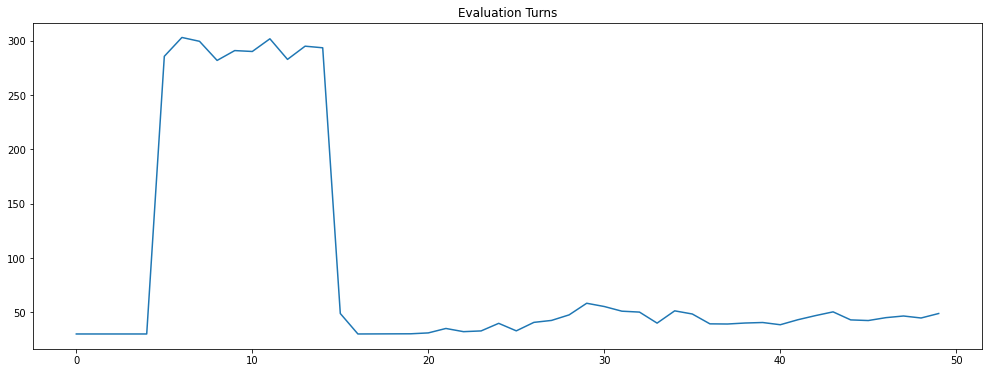

In [11]:
plt.figure(figsize=(17, 6))
plt.title("Evaluation Turns")
plt.plot(eval_mean_turns)
plt.show()

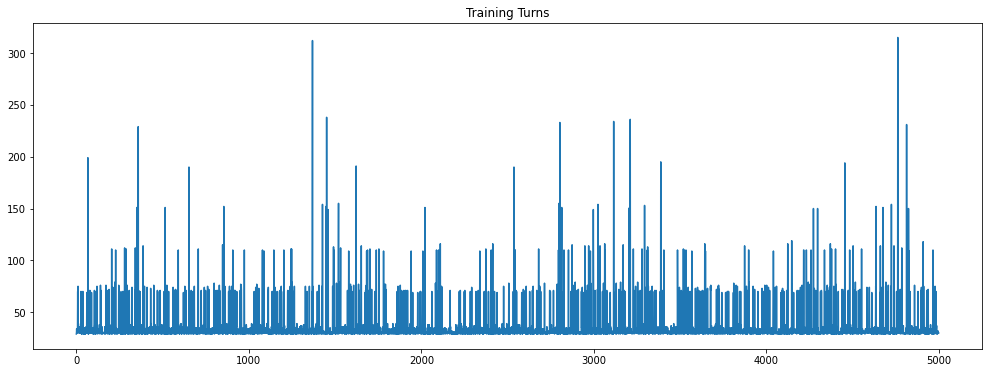

In [12]:
plt.figure(figsize=(17, 6))
plt.title("Training Turns")
plt.plot(train_turns)
plt.show()